In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

### Hyperparameters


In [2]:
pre_trained = "bert-base-german-cased"
#pre_trained = "smanjil/German-MedBERT"
epochs = 35
batch_size = 30
drop_out = 0.2
learning_rate = 1e-4 #1e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  
dataset['Text'] = dataset['Text'].astype(str)


In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.3963473180065984
Validation loss: 1.052654770704416
F1 Score (Weighted): 0.5732931358201513


Epoch 2:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8934377984724183
Validation loss: 0.9625797271728516
F1 Score (Weighted): 0.6864526024774118


Epoch 3:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5650509068931359
Validation loss: 0.9557008456725341
F1 Score (Weighted): 0.7043772741091724


Epoch 4:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.414634576526241
Validation loss: 1.019546785320227
F1 Score (Weighted): 0.7335223465345866


Epoch 5:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.35207046827544336
Validation loss: 1.0239374222090611
F1 Score (Weighted): 0.6992183989894233


Epoch 6:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2730118679827538
Validation loss: 1.2046981843618245
F1 Score (Weighted): 0.6813482817686128


Epoch 7:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.26610658647141594
Validation loss: 1.2035083770751953
F1 Score (Weighted): 0.7146561809326251


Epoch 8:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.19091027975082397
Validation loss: 1.375805886892172
F1 Score (Weighted): 0.6970520890072425


Epoch 9:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.18238493186030266
Validation loss: 1.5421825326406038
F1 Score (Weighted): 0.7205181795362862


Epoch 10:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.16168040793011154
Validation loss: 1.700939150956961
F1 Score (Weighted): 0.6800500024476894


Epoch 11:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.14299600506606308
Validation loss: 1.621478713475741
F1 Score (Weighted): 0.6994611797456558


Epoch 12:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.1284739031571139
Validation loss: 1.6424021675036504
F1 Score (Weighted): 0.7232448732543657


Epoch 13:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.14005691766657907
Validation loss: 1.90587429358409
F1 Score (Weighted): 0.69160613757415


Epoch 14:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.11449788062347342
Validation loss: 1.7220990566106944
F1 Score (Weighted): 0.6986501907908683


Epoch 15:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.10314585221931338
Validation loss: 1.798153281211853
F1 Score (Weighted): 0.7097479418953767


Epoch 16:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.1134022511575587
Validation loss: 1.8142969058110163
F1 Score (Weighted): 0.6890724926802289


Epoch 17:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.08824271676333054
Validation loss: 1.8555812010398278
F1 Score (Weighted): 0.6975854538613143


Epoch 18:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.08517415603568805
Validation loss: 1.7337377804976244
F1 Score (Weighted): 0.7159146382608144


Epoch 19:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.07302069964319252
Validation loss: 1.9235157416417048
F1 Score (Weighted): 0.7068125199923726


Epoch 20:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.06938042872892422
Validation loss: 1.997105937737685
F1 Score (Weighted): 0.709959238715426


Epoch 21:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.05578670254233631
Validation loss: 2.07423105606666
F1 Score (Weighted): 0.7271377327683928


Epoch 22:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.0499368625266167
Validation loss: 2.0434778286860538
F1 Score (Weighted): 0.7175018834127429


Epoch 23:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.04370976662671571
Validation loss: 2.0764450018222513
F1 Score (Weighted): 0.7211351988876009


Epoch 24:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.034949139262502336
Validation loss: 2.175985107055077
F1 Score (Weighted): 0.7184447380592469


Epoch 25:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.0431250384013317
Validation loss: 2.2096657936389628
F1 Score (Weighted): 0.7111294262556678


Epoch 26:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.037075926262912326
Validation loss: 2.1243112820845385
F1 Score (Weighted): 0.7161801777761038


Epoch 27:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.03440008060736717
Validation loss: 2.2225372332793016
F1 Score (Weighted): 0.7148799265860288


Epoch 28:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.04534136158906841
Validation loss: 2.122774738531846
F1 Score (Weighted): 0.7183764628443348


Epoch 29:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.03453057558204898
Validation loss: 2.0418276603405294
F1 Score (Weighted): 0.713656326106919


Epoch 30:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.03571850278219073
Validation loss: 2.057626348275405
F1 Score (Weighted): 0.7251197676300764


Epoch 31:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.03151966589781375
Validation loss: 2.178304387972905
F1 Score (Weighted): 0.7180804795456338


Epoch 32:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.03159729777109823
Validation loss: 2.199472812505869
F1 Score (Weighted): 0.726110659495808


Epoch 33:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.03249002861422554
Validation loss: 2.1982438289202175
F1 Score (Weighted): 0.7152841255794563


Epoch 34:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.029049613170133416
Validation loss: 2.123018824137174
F1 Score (Weighted): 0.7295025681389781


Epoch 35:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.02998724926357576
Validation loss: 2.134674448233384
F1 Score (Weighted): 0.726814212578463


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((i+1, accuracy))
print(total_acc)

[(1, 0.5732931358201513), (2, 0.6864526024774118), (3, 0.7043772741091724), (4, 0.7335223465345866), (5, 0.6992183989894233), (6, 0.6813482817686128), (7, 0.7146561809326251), (8, 0.6970520890072425), (9, 0.7205181795362862), (10, 0.6800500024476894), (11, 0.6994611797456558), (12, 0.7232448732543657), (13, 0.69160613757415), (14, 0.6986501907908683), (15, 0.7097479418953767), (16, 0.6890724926802289), (17, 0.6975854538613143), (18, 0.7159146382608144), (19, 0.7068125199923726), (20, 0.709959238715426), (21, 0.7271377327683928), (22, 0.7175018834127429), (23, 0.7211351988876009), (24, 0.7184447380592469), (25, 0.7111294262556678), (26, 0.7161801777761038), (27, 0.7148799265860288), (28, 0.7183764628443348), (29, 0.713656326106919), (30, 0.7251197676300764), (31, 0.7180804795456338), (32, 0.726110659495808), (33, 0.7152841255794563), (34, 0.7295025681389781), (35, 0.726814212578463)]


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(1, 0.5301186120560867), (2, 0.6347441209181072), (3, 0.6584747798267293), (4, 0.6868597102257533), (5, 0.6558026201889707), (6, 0.644222550913144), (7, 0.6716128968688126), (8, 0.6558639808611846), (9, 0.6767960417860719), (10, 0.6419294119081062), (11, 0.6629079850536016), (12, 0.6762296219178788), (13, 0.6539668119724755), (14, 0.6566297994214058), (15, 0.6733066909656341), (16, 0.651108303615246), (17, 0.6627120665353162), (18, 0.6713184889447369), (19, 0.6642451512385626), (20, 0.6718878175581137), (21, 0.6875448900044564), (22, 0.6775816925022989), (23, 0.6796107473197014), (24, 0.67668908524304), (25, 0.6687625281094508), (26, 0.6751025399217264), (27, 0.6685860262121449), (28, 0.6766451091440498), (29, 0.6709512037816143), (30, 0.6834269732009348), (31, 0.676783968456622), (32, 0.6854699802179255), (33, 0.6737536654263191), (34, 0.691034928494624), (35, 0.687411740088827)]


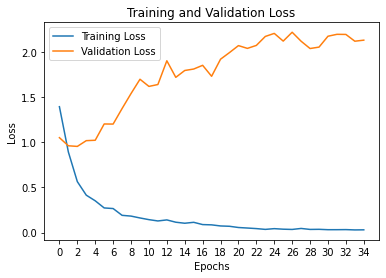

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()